### 🧠 What is Query Planning and Decomposition?
Query Planning and Decomposition is a technique where a complex user query is broken down into simpler sub-questions or tasks, allowing a system (like a RAG agent) to:

- Understand the question more deeply
- Retrieve more precise and complete information
- Execute step-by-step reasoning

It's like reverse-engineering a question into manageable steps before answering.

🧠 What's New in This Version?
- ✅ Add a Query Planner Node
- ✅ Break complex user queries into sub-questions
- ✅ Retrieve docs per sub-question
- ✅ Combine all retrieved contexts
- ✅ Generate a final consolidated answer

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader,WebBaseLoader
from langgraph.graph import StateGraph, END

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

✓ Gemini model initialized for reranking


/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import time
from typing import List

# ----------------------------
# 1. Load and Embed Documents
# ----------------------------
"""
Load documents from web URLs and create vector embeddings with rate limiting.
This implementation handles Google API free tier limitations by processing
documents in batches with time delays between requests.
"""

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

# Load documents from web sources
docs = []
for url in urls:
    docs.extend(WebBaseLoader(url).load())

# Split documents into manageable chunks for embedding
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

print(f"Total chunks to embed: {len(chunks)}")

# Configure rate limiting for Google API free tier
batch_size = 5  # Maximum 5 chunks per batch for free tier
delay_between_batches = 2.0  # 2 seconds delay between batches

embedding = embedding_model

# Create batches of chunks to process sequentially
chunk_batches = [chunks[i:i + batch_size] for i in range(0, len(chunks), batch_size)]

print(f"Processing {len(chunk_batches)} batches with {delay_between_batches}s delay between batches...")

# Initialize vectorstore with first batch
print(f"Processing batch 1/{len(chunk_batches)} ({len(chunk_batches[0])} chunks)")
vectorstore = FAISS.from_documents(chunk_batches[0], embedding)

# Process remaining batches with rate limiting
for i, batch in enumerate(chunk_batches[1:], 2):
    print(f"Waiting {delay_between_batches}s before processing batch {i}...")
    time.sleep(delay_between_batches)
    
    print(f"Processing batch {i}/{len(chunk_batches)} ({len(batch)} chunks)")
    batch_vectorstore = FAISS.from_documents(batch, embedding)
    
    # Merge batch results into main vectorstore
    vectorstore.merge_from(batch_vectorstore)

retriever = vectorstore.as_retriever()
print("✓ All chunks embedded and vectorstore created successfully")

Total chunks to embed: 234
Processing 47 batches with 2.0s delay between batches...
Processing batch 1/47 (5 chunks)
Waiting 2.0s before processing batch 2...
Processing batch 2/47 (5 chunks)
Waiting 2.0s before processing batch 3...
Processing batch 3/47 (5 chunks)
Waiting 2.0s before processing batch 4...
Processing batch 4/47 (5 chunks)
Waiting 2.0s before processing batch 5...
Processing batch 5/47 (5 chunks)
Waiting 2.0s before processing batch 6...
Processing batch 6/47 (5 chunks)
Waiting 2.0s before processing batch 7...
Processing batch 7/47 (5 chunks)
Waiting 2.0s before processing batch 8...
Processing batch 8/47 (5 chunks)
Waiting 2.0s before processing batch 9...
Processing batch 9/47 (5 chunks)
Waiting 2.0s before processing batch 10...
Processing batch 10/47 (5 chunks)
Waiting 2.0s before processing batch 11...
Processing batch 11/47 (5 chunks)
Waiting 2.0s before processing batch 12...
Processing batch 12/47 (5 chunks)
Waiting 2.0s before processing batch 13...
Processin

In [ ]:
# ----------------------------
# 2. State Schema
# ----------------------------
"""
Define the state schema for the RAG workflow.
Tracks the question, sub-questions, retrieved documents, and final answer.
"""

class RAGState(BaseModel):
    """State container for Query Planning and Decomposition RAG workflow."""
    question: str                        # Original user question
    sub_questions: List[str] = []        # Decomposed sub-questions
    retrieved_docs: List[Document] = []  # Documents retrieved for all sub-questions
    answer: str = ""                     # Final generated answer

In [ ]:
# ----------------------------
# 3. Nodes
# ----------------------------

def plan_query(state: RAGState) -> RAGState:
    """
    Query Planning Node: Decomposes complex questions into sub-questions.
    
    Takes a complex user query and breaks it down into 2-3 manageable
    sub-questions that can be answered more effectively.
    """
    prompt = f"""
Break the following complex question into 2-3 sub-questions:

Question: {state.question}

Sub-questions:
"""
    result = llm.invoke(prompt)
    sub_questions = [line.strip("- ").strip() for line in result.content.strip().split("\n") if line.strip()]
    return RAGState(question=state.question, sub_questions=sub_questions)

def retrieve_for_each(state: RAGState) -> RAGState:
    """
    Retrieval Node: Fetches relevant documents for each sub-question.
    
    Performs vector similarity search for each sub-question and aggregates
    all retrieved documents for comprehensive context.
    """
    all_docs = []
    for sub in state.sub_questions:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=all_docs)

def generate_final_answer(state: RAGState) -> RAGState:
    """
    Generation Node: Creates comprehensive answer using retrieved context.
    
    Combines all retrieved documents and generates a final answer that
    addresses the original complex question holistically.
    """
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the context below to answer the question.

Context:
{context}

Question: {state.question}
"""
    
    answer = llm.invoke(prompt).content
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=state.retrieved_docs, answer=answer)

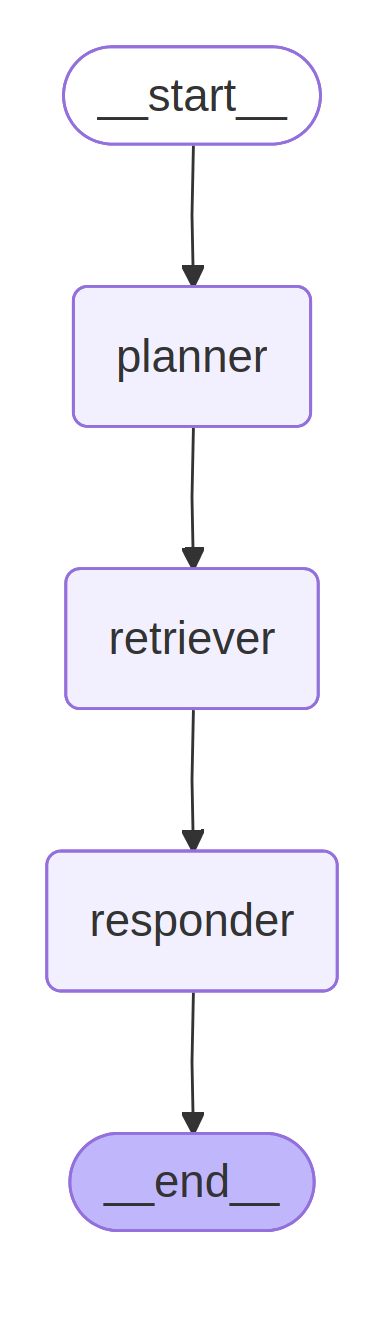

In [ ]:
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()

# ----------------------------
# 4. Build LangGraph
# ----------------------------
"""
Constructs the RAG workflow graph with three sequential nodes:
1. Planner: Decomposes complex queries into sub-questions
2. Retriever: Fetches relevant documents for each sub-question
3. Responder: Generates final answer using all retrieved context
"""

builder = StateGraph(RAGState)

# Add workflow nodes
builder.add_node("planner", plan_query)
builder.add_node("retriever", retrieve_for_each)
builder.add_node("responder", generate_final_answer)

# Define workflow execution path
builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

# Compile the graph for execution
graph = builder.compile()

# Visualize the workflow graph
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

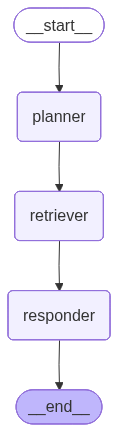

In [10]:
graph

In [ ]:
# ----------------------------
# 5. Run the pipeline
# ----------------------------
"""
Execute the Query Planning and Decomposition RAG pipeline.
Demonstrates how complex questions are broken down and answered comprehensively.
"""

if __name__ == "__main__":
    user_query = "Explain how agent loops work and what are the challenges in diffusion video generation?"
    initial_state = RAGState(question=user_query)
    final_state = graph.invoke(initial_state)
    print(final_state)

    print("\n🔍 Sub-questions:")
    for q in final_state['sub_questions']:
        print("-", q)

    print("\n✅ Final Answer:\n", final_state['answer'])

{'question': 'Explain how agent loops work and what are the challenges in diffusion video generation?', 'sub_questions': ['Here are three sub-questions that break down the original question:', '1.  **What is an agent loop and how does it function in the context of AI systems?** (This focuses on defining and explaining the core concept of agent loops.)', '2.  **What is diffusion video generation, and what are the key steps involved in the process?** (This focuses on defining and explaining the core concept of diffusion video generation.)', '3.  **What are the major challenges and limitations currently faced in diffusion video generation?** (This focuses on the specific difficulties encountered in this field.)'], 'retrieved_docs': [Document(id='6428406f-04ed-41ec-9a3e-c68ff2646915', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core cont